In [47]:
import numpy as np
import pandas as pd
from Pyfrontier.frontier_model import EnvelopDEA

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost
from lightgbm import LGBMRegressor

In [2]:
rawData = pd.read_csv("/Users/dilshod/Downloads/RussianBankDataCorr.csv", index_col=0)

In [3]:
rawData

,id,name,year,tip,pok,value
0,1,SBERBANK OF RUSSIA,2012,BIG,index,0.000000e+00
1,1,SBERBANK OF RUSSIA,2012,BIG,Assets,4.970714e+08
2,1,SBERBANK OF RUSSIA,2012,BIG,CIR,5.048000e+01
3,1,SBERBANK OF RUSSIA,2012,BIG,CoefficientOfAdequacyOfOwnCapital,1.370000e+01
4,1,SBERBANK OF RUSSIA,2012,BIG,DepositsAndShort-termFinancing,4.034643e+08
...,...,...,...,...,...,...
29541,315,SINERGIYA OAO,2017,NANO,Data,2.017000e+03
29542,315,SINERGIYA OAO,2017,NANO,DEP,4.868145e-01
29543,315,SINERGIYA OAO,2017,NANO,TAssets,9.879656e+00
29544,315,SINERGIYA OAO,2017,NANO,NIM,1.080000e+01


In [4]:
data = rawData.drop(columns=['id', 'tip']).pivot_table(index=['name', 'year'], columns='pok', values='value').reset_index()

In [5]:
data['name'] = data['name'] + " " + data['year'].astype(str)
data = data.rename_axis(None, axis=1)
data = data.drop(columns=['year', 'Data', 'index'])
data = data.sort_values(by=['TAssets'], ascending=False)
data.index = np.arange(0, len(data))

In [6]:
data = data.dropna()

In [7]:
data

,name,Assets,CAR,CIR,CoefficientOfAdequacyOfOwnCapital,DEP,DepositsAndShort-termFinancing,InterestIncome,LOAN,NII,NIM,NetInterestMargin,OOD,OtherOperatingIncome,ROA,ROE,RQA,TAssets,Tier1
0,SBERBANK OF RUSSIA 2013,556393068.0,13.40,45.73,13.40,0.819575,456005646.0,45176784.0,71.02,0.144725,5.97,5.97,583577.0,7644550.0,2.17,20.66,4.51,20.136986,10.60
1,SBERBANK OF RUSSIA 2012,497071356.0,13.70,50.48,13.70,0.811683,403464273.0,38103295.0,69.54,0.172411,6.44,6.44,1293925.0,7938049.0,2.68,24.06,5.11,20.024244,10.40
2,SBERBANK OF RUSSIA 2020,487521621.0,14.70,36.24,14.70,0.760626,370821539.0,32477527.0,64.93,0.209821,5.43,5.43,1784078.0,8623946.0,2.30,15.95,6.49,20.004845,14.30
3,SBERBANK OF RUSSIA 2019,483957068.0,14.80,37.73,14.80,0.747250,361637148.0,38704030.0,67.97,0.198045,5.41,5.41,297226.0,9558086.0,2.76,20.26,6.37,19.997507,14.50
4,SBERBANK OF RUSSIA 2017,470696273.0,13.00,35.23,13.00,0.782648,368389338.0,37003343.0,68.19,0.192468,5.81,5.81,1397565.0,8819414.0,2.73,22.87,7.05,19.969724,11.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,BANK STANDARD-CREDIT 2020,9509.0,40.92,107.30,40.92,0.668314,6355.0,841.0,42.73,0.152218,10.16,10.16,-43.0,151.0,-3.89,-12.01,3.80,9.159994,30.70
1494,BANK STANDARD-CREDIT 2018,9088.0,40.60,161.08,40.60,0.478983,4353.0,950.0,42.37,0.133212,10.93,10.93,133.0,146.0,-5.21,-12.93,14.81,9.114710,32.00
1496,NATIONAL SAVINGS BANK 2016,7943.0,8.00,100.04,8.00,0.275589,2189.0,614.0,37.34,0.223767,10.57,10.57,123.0,177.0,-8.55,-12.46,25.08,8.980046,6.00
1497,"JSC RNCO ""KHOLMSK 2020",7372.0,37.43,125.41,37.43,0.780792,5756.0,129.0,3.80,0.857459,0.93,0.93,294.0,776.0,-1.38,-6.60,2.41,8.905444,15.08


In [8]:
# data[['Assets', 'DepositsAndShort-termFinancing', 'InterestIncome', 'OtherOperatingIncome']] = data[['Assets', 'DepositsAndShort-termFinancing', 'InterestIncome', 'OtherOperatingIncome']] * 1e-6

In [9]:
# roa = (net_income + interest_expense) / Total Assets => net_income = roa * TAssets - interest_expense

In [10]:
# owners_equity, operatioanl_expenses -> operational_income, net_income

Чистая процентная маржа, NIM (Net Interest Margin) – коэффициент, характеризующий эффективность проведения активных операций. Это один из основных показателей, применяемый для оценки динамики процентных доходов банка и стоимость его фондирования относительно активов.

Отличие между показателями заключается в том, что в расчёт ROA включаются все активы, в том числе привлечённые, а в расчёт ROE - только собственные. Разница между ними демонстрирует, насколько велик так называемый «финансовый рычаг» (доля привлечённых ресурсов): чем она больше, тем больше размер финансового рычага.

In [11]:
dea_features = data[['name', 'DepositsAndShort-termFinancing', 'CAR', 'InterestIncome', 'NIM']]

In [16]:
dea_features.head()

,name,DepositsAndShort-termFinancing,CAR,InterestIncome,NIM
0,SBERBANK OF RUSSIA 2013,456005646.0,13.4,45176784.0,5.97
1,SBERBANK OF RUSSIA 2012,403464273.0,13.7,38103295.0,6.44
2,SBERBANK OF RUSSIA 2020,370821539.0,14.7,32477527.0,5.43
3,SBERBANK OF RUSSIA 2019,361637148.0,14.8,38704030.0,5.41
4,SBERBANK OF RUSSIA 2017,368389338.0,13.0,37003343.0,5.81


In [17]:
dea = EnvelopDEA(frontier="CRS", orient="in")
dea.fit(inputs=dea_features[['DepositsAndShort-termFinancing', 'CAR']].to_numpy(), outputs=dea_features[['InterestIncome', 'NIM']].to_numpy())

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /usr/local/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_b/f62_3kh151x02tlww4dcpdtr0000gn/T/4c4f9ddc17e848e9a05ada56a4951577-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/_b/f62_3kh151x02tlww4dcpdtr0000gn/T/4c4f9ddc17e848e9a05ada56a4951577-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 4013 RHS
At line 4018 BOUNDS
At line 4019 ENDATA
Problem MODEL has 4 rows, 1001 columns and 4002 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 1001 (0) columns and 4002 (0) elements
Perturbing problem by 0.001% of 0.022823905 - largest nonzero change 3.884984e-06 ( 0.017021557%) - largest zero change 3.8844467e-06
0  Obj 0 Primal inf 1088.1784 (2)
11  Obj 1.0002633
Optimal - objective value 1
Optimal objective 1 - 11 iterations time 0.002

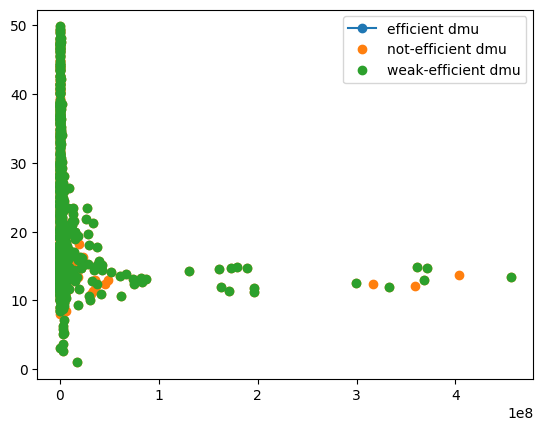

In [21]:
eff_dmu = [r.dmu for r in dea.result if r.is_efficient]
ineff_dmu = [r.dmu for r in dea.result if r.is_efficient != 1]
weak_eff_dmu = [r.dmu for r in dea.result if r.has_slack]

plt.figure()
plt.plot(
    [d.input[0] for d in eff_dmu],
    [d.input[1] for d in eff_dmu],
    "-o",
    label="efficient dmu",
)
plt.plot(
    [d.input[0] for d in ineff_dmu],
    [d.input[1] for d in ineff_dmu],
    "o",
    label="not-efficient dmu",
)
plt.plot(
    [d.input[0] for d in weak_eff_dmu],
    [d.input[1] for d in weak_eff_dmu],
    "o",
    label="weak-efficient dmu",
)
plt.plot([4, 6], [1, 1], linestyle="--", color="black")
plt.legend()
plt.show()

In [27]:
scores = np.array([r.score for r in dea.result])

In [32]:
dea_features.insert(len(dea_features.columns), 'Score', scores)

In [33]:
dea_features

,name,DepositsAndShort-termFinancing,CAR,InterestIncome,NIM,Score
0,SBERBANK OF RUSSIA 2013,456005646.0,13.40,45176784.0,5.97,1.000000
1,SBERBANK OF RUSSIA 2012,403464273.0,13.70,38103295.0,6.44,0.847101
2,SBERBANK OF RUSSIA 2020,370821539.0,14.70,32477527.0,5.43,0.734072
3,SBERBANK OF RUSSIA 2019,361637148.0,14.80,38704030.0,5.41,0.895521
4,SBERBANK OF RUSSIA 2017,368389338.0,13.00,37003343.0,5.81,0.865231
...,...,...,...,...,...,...
1493,BANK STANDARD-CREDIT 2020,6355.0,40.92,841.0,10.16,0.129781
1494,BANK STANDARD-CREDIT 2018,4353.0,40.60,950.0,10.93,0.176383
1496,NATIONAL SAVINGS BANK 2016,2189.0,8.00,614.0,10.57,0.529997
1497,"JSC RNCO ""KHOLMSK 2020",5756.0,37.43,129.0,0.93,0.021876


In [34]:
# now we have dea scores for each dmu

In [40]:
X = dea_features[['DepositsAndShort-termFinancing', 'CAR', 'InterestIncome', 'NIM']]
Y = dea_features['Score']

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=98987)

In [48]:
parameters = {
    "learning_rate": (0.001, 0.01, ),
    "max_depth": [ 2, 4],
    "min_child_weight": [ 1, 10],
    "gamma":[ 0.0,],
    "n_estimators": [1000, 5000]
}
xgb = xgboost.XGBRegressor()
xgb_gs = GridSearchCV(xgb, parameters, verbose=2, cv=3)
xgb_gs.fit(x_train, y_train);

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=1000; total time=   1.8s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=1000; total time=   0.7s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=1000; total time=   0.6s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=5000; total time=   3.2s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=5000; total time=   3.0s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=1, n_estimators=5000; total time=   3.0s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=10, n_estimators=1000; total time=   0.6s
[CV] END gamma=0.0, learning_rate=0.001, max_depth=2, min_child_weight=10, n_estimators=1000; total time=   0.6s
[CV] END gamma=0.0, learning_rate=0.001, 

In [49]:
best_scores = {}

In [51]:
print(xgb_gs.best_params_)
best_scores["XGBoost"] = np.abs(xgb_gs.predict(x_test) - y_test)

{'gamma': 0.0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 5000}


In [53]:
parameters = {
    'num_leaves': (40, 20, 10,),
    'learning_rate': (0.1, 0.01, 0.05),
    'max_depth': (-1,),
    'n_estimators': (10**3, 10**4),}

lgbmr_gs = GridSearchCV(LGBMRegressor(), parameters, verbose=2)
lgbmr_gs.fit(x_train, y_train);

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   3.0s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   1.2s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=40; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total time=   1.0s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total time=   3.0s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=20; total ti

In [54]:
print(lgbmr_gs.best_params_)
best_scores["LightGBM"] = np.abs(lgbmr_gs.predict(x_test) - y_test)

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 10000, 'num_leaves': 10}


In [57]:
np.sum(best_scores["LightGBM"]), np.sum(best_scores["XGBoost"])

(3.111960001522311, 3.1441609496438505)

In [ ]:
# lightgbm показал лучше результаты

In [58]:
best_scores["LightGBM"]

578     0.011797
857     0.016399
738     0.049367
522     0.006427
21      0.043284
          ...   
1101    0.010982
1006    0.030500
243     0.003412
754     0.002450
529     0.032443
Name: Score, Length: 100, dtype: float64